In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
ds_train, ds_info = tfds.load("malaria",split="train[:90%]", as_supervised=True, shuffle_files=True, with_info=True)
ds_valid = tfds.load("malaria",split="train[90%:100%]", as_supervised=True, shuffle_files=True)

In [3]:
def findMinMax(ds1, ds2):
    minX1 = min(i[0].shape[0] for i in ds1)
    minY1 = min(i[0].shape[1] for i in ds1)

    minX2 = min(i[0].shape[0] for i in ds2)
    minY2 = min(i[0].shape[1] for i in ds2)
    return min(minX1, minX2), min(minY1, minY2)


minX, minY = findMinMax(ds_train, ds_valid)
print(minX, minY)

40 46


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.image.resize(image, [minY, minX])
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label,2)

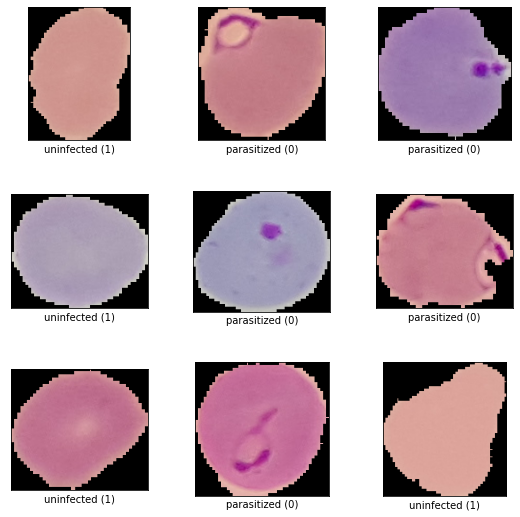

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

# normalize the data and turn it into floats
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache() # not very usefull since data is very small
ds_train = ds_train.shuffle(round(ds_info.splits['train'].num_examples*0.9))
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_valid = ds_valid.map(normalize_img)
ds_valid = ds_valid.cache() # not very usefull since data is very small
ds_valid = ds_valid.batch(64)
ds_valid = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


In [20]:
model = keras.Sequential([

    # First Convolutional Block
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(46, 40, 3)),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Classifier Head
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 44, 38, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 19, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 8, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 6, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # if gpu has low memory this limits the size tf is allowed to use
    # using to much space can lead to breakage
   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4048)])
  except RuntimeError as e:
   print(e)

with tf.device("/device:GPU:0"):
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=5,
    )


Epoch 1/5
388/388 [==============================] - 39s 100ms/step - loss: 0.6722 - accuracy: 0.5917 - val_loss: 0.6445 - val_accuracy: 0.6222
Epoch 2/5
388/388 [==============================] - 38s 98ms/step - loss: 0.6108 - accuracy: 0.6853 - val_loss: 0.6092 - val_accuracy: 0.6827
Epoch 3/5
388/388 [==============================] - 38s 98ms/step - loss: 0.5656 - accuracy: 0.7178 - val_loss: 0.5363 - val_accuracy: 0.7778
Epoch 4/5
388/388 [==============================] - 42s 108ms/step - loss: 0.4896 - accuracy: 0.7722 - val_loss: 0.3935 - val_accuracy: 0.8398
Epoch 5/5
388/388 [==============================] - 38s 99ms/step - loss: 0.3666 - accuracy: 0.8464 - val_loss: 0.2993 - val_accuracy: 0.8787
